# 🚀 Modèle Avancé - BERT Fine-tuning

Ce notebook entraîne un modèle BERT fine-tuné pour la détection de toxicité.

## Objectifs
- 🤖 Fine-tuner BERT pré-entraîné
- 📈 Améliorer le F1-Score (objectif > 0.75)
- ⚡ Optimiser pour l'inférence
- 🔄 Comparer avec le modèle simple

In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import time
import os
import json
from datetime import datetime
from tqdm.auto import tqdm

# Transformers et tokenizers
from transformers import (
    AutoTokenizer, 
    AutoModelForSequenceClassification,
    TrainingArguments, 
    Trainer,
    DataCollatorWithPadding
)
from datasets import Dataset

# Scikit-learn pour métriques
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score,
    classification_report, confusion_matrix, roc_auc_score
)
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

# Configuration
plt.style.use('default')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)

# Vérifier CUDA
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"📦 Imports terminés !")
print(f"🖥️ Device: {device}")
print(f"🕐 Démarrage: {datetime.now().strftime('%H:%M:%S')}")

if torch.cuda.is_available():
    print(f"🚀 GPU disponible: {torch.cuda.get_device_name(0)}")
    print(f"💾 Mémoire GPU: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")
else:
    print("⚠️ CPU seulement - L'entraînement sera plus lent")

📦 Imports terminés !
🖥️ Device: cpu
🕐 Démarrage: 12:08:53
⚠️ CPU seulement - L'entraînement sera plus lent


## 1. 📁 Chargement des Données

In [2]:
# Chargement des données préprocessées
print("📊 Chargement des données préprocessées...")

train_df = pd.read_csv('../data/train_preprocessed.csv')
test_df = pd.read_csv('../data/test_preprocessed.csv')

print(f"✅ Train: {train_df.shape[0]:,} lignes")
print(f"✅ Test: {test_df.shape[0]:,} lignes")

# Préparation des données pour BERT (texte léger)
X_train_text = train_df['comment_bert'].fillna('').astype(str)
y_train = train_df['is_toxic'].fillna(0).astype(int)

# Split train/validation pour BERT (plus petit validation set pour économiser temps)
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train_text, y_train, 
    test_size=0.15,  # 15% pour validation (vs 20% avant)
    random_state=42, 
    stratify=y_train
)

print(f"\n📊 Split BERT train/validation:")
print(f"  Train: {len(X_train_split):,} textes")
print(f"  Validation: {len(X_val_split):,} textes")
print(f"  Train toxic: {y_train_split.sum():,} ({y_train_split.sum()/len(y_train_split)*100:.1f}%)")
print(f"  Val toxic: {y_val_split.sum():,} ({y_val_split.sum()/len(y_val_split)*100:.1f}%)")

# Échantillonner pour test rapide (optionnel)
SAMPLE_SIZE = 5000  # Réduire pour test rapide, mettre None pour tout
if SAMPLE_SIZE and len(X_train_split) > SAMPLE_SIZE:
    print(f"\n🔬 MODE TEST: Échantillonnage à {SAMPLE_SIZE} exemples...")
    
    # Stratified sampling
    X_train_sample, _, y_train_sample, _ = train_test_split(
        X_train_split, y_train_split,
        train_size=SAMPLE_SIZE,
        random_state=42,
        stratify=y_train_split
    )
    
    X_val_sample, _, y_val_sample, _ = train_test_split(
        X_val_split, y_val_split,
        train_size=min(1000, len(X_val_split)),  # Max 1000 pour validation
        random_state=42,
        stratify=y_val_split
    )
    
    X_train_split, y_train_split = X_train_sample, y_train_sample
    X_val_split, y_val_split = X_val_sample, y_val_sample
    
    print(f"  Train échantillonné: {len(X_train_split):,}")
    print(f"  Validation échantillonné: {len(X_val_split):,}")

📊 Chargement des données préprocessées...
✅ Train: 20,000 lignes
✅ Test: 20,000 lignes

📊 Split BERT train/validation:
  Train: 17,000 textes
  Validation: 3,000 textes
  Train toxic: 1,751 (10.3%)
  Val toxic: 309 (10.3%)

🔬 MODE TEST: Échantillonnage à 5000 exemples...
  Train échantillonné: 5,000
  Validation échantillonné: 1,000


## 2. 🤖 Configuration du Modèle BERT

In [3]:
# Choisir le modèle BERT (distilbert pour être plus rapide)
MODEL_NAME = "distilbert-base-uncased"  # Plus léger et rapide que bert-base-uncased

print(f"🤖 Chargement du modèle: {MODEL_NAME}")

# Charger tokenizer et modèle
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=2,  # Binaire: toxic/non-toxic
    problem_type="single_label_classification"
)

# Déplacer vers GPU si disponible
model.to(device)

print(f"✅ Modèle chargé sur {device}")
print(f"📏 Longueur max tokens: {tokenizer.model_max_length}")
print(f"🔢 Nombre de paramètres: {sum(p.numel() for p in model.parameters()):,}")

🤖 Chargement du modèle: distilbert-base-uncased


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Modèle chargé sur cpu
📏 Longueur max tokens: 512
🔢 Nombre de paramètres: 66,955,010


## 3. 🔤 Tokenisation des Données

In [4]:
# Configuration de tokenisation
MAX_LENGTH = 128  # Réduire pour être plus rapide (vs 512 par défaut)

def tokenize_function(texts):
    """Tokenise les textes pour BERT"""
    return tokenizer(
        texts,
        truncation=True,
        padding=True,
        max_length=MAX_LENGTH,
        return_tensors="pt"
    )

print(f"🔤 Tokenisation des données (max_length={MAX_LENGTH})...")

# Tokeniser train
print("  Tokenisation train...")
train_encodings = tokenize_function(X_train_split.tolist())

# Tokeniser validation
print("  Tokenisation validation...")
val_encodings = tokenize_function(X_val_split.tolist())

print(f"✅ Tokenisation terminée")
print(f"📏 Shape train tokens: {train_encodings['input_ids'].shape}")
print(f"📏 Shape val tokens: {val_encodings['input_ids'].shape}")

# Analyser la distribution des longueurs
train_lengths = (train_encodings['attention_mask'].sum(dim=1)).numpy()
print(f"\n📊 Longueurs des séquences tokenisées:")
print(f"  Moyenne: {train_lengths.mean():.1f} tokens")
print(f"  Médiane: {np.median(train_lengths):.1f} tokens")
print(f"  Max: {train_lengths.max()} tokens")
print(f"  % tronqués: {(train_lengths == MAX_LENGTH).mean() * 100:.1f}%")

🔤 Tokenisation des données (max_length=128)...
  Tokenisation train...
  Tokenisation validation...
✅ Tokenisation terminée
📏 Shape train tokens: torch.Size([5000, 128])
📏 Shape val tokens: torch.Size([1000, 128])

📊 Longueurs des séquences tokenisées:
  Moyenne: 63.9 tokens
  Médiane: 53.0 tokens
  Max: 128 tokens
  % tronqués: 19.9%


## 4. 📚 Création des Datasets

In [5]:
# Créer les datasets HuggingFace
class ToxicityDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels.iloc[idx] if hasattr(self.labels, 'iloc') else self.labels[idx], dtype=torch.long)
        return item

    def __len__(self):
        return len(self.labels)

# Créer les datasets
train_dataset = ToxicityDataset(train_encodings, y_train_split)
val_dataset = ToxicityDataset(val_encodings, y_val_split)

print(f"📚 Datasets créés:")
print(f"  Train dataset: {len(train_dataset):,} exemples")
print(f"  Val dataset: {len(val_dataset):,} exemples")

# Test d'un échantillon
sample = train_dataset[0]
print(f"\n🔍 Test échantillon:")
print(f"  Input shape: {sample['input_ids'].shape}")
print(f"  Label: {sample['labels'].item()}")
print(f"  Attention mask shape: {sample['attention_mask'].shape}")

📚 Datasets créés:
  Train dataset: 5,000 exemples
  Val dataset: 1,000 exemples

🔍 Test échantillon:
  Input shape: torch.Size([128])
  Label: 0
  Attention mask shape: torch.Size([128])


## 5. ⚙️ Configuration de l'Entraînement

In [6]:
# Installer et importer les dépendances nécessaires
import subprocess
import sys

try:
    from transformers import TrainingArguments
except ImportError:
    print("📦 Installation de transformers[torch]...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "transformers[torch]", "--quiet"])
    from transformers import TrainingArguments

# Définir les métriques d'évaluation
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    
    accuracy = accuracy_score(labels, predictions)
    f1 = f1_score(labels, predictions)
    precision = precision_score(labels, predictions)
    recall = recall_score(labels, predictions)
    
    return {
        'accuracy': accuracy,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

# Approche simplifiée BERT sans Trainer HuggingFace
print("🤖 Configuration d'entraînement BERT simplifiée...")
print("⚠️ Utilisation de PyTorch natif au lieu du Trainer HuggingFace")

# Configuration d'entraînement manuelle
LEARNING_RATE = 2e-5
NUM_EPOCHS = 2
BATCH_SIZE = 16
MAX_LENGTH = 128

print(f"⚙️ Configuration:")
print(f"  Learning rate: {LEARNING_RATE}")
print(f"  Epochs: {NUM_EPOCHS}")
print(f"  Batch size: {BATCH_SIZE}")
print(f"  Max length: {MAX_LENGTH}")
print(f"  Device: {device}")

# Créer les DataLoaders PyTorch
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"📚 DataLoaders créés:")
print(f"  Train batches: {len(train_dataloader)}")
print(f"  Val batches: {len(val_dataloader)}")

# Optimiseur et scheduler
from torch.optim import AdamW
from torch.optim.lr_scheduler import LinearLR

optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)
total_steps = len(train_dataloader) * NUM_EPOCHS
scheduler = LinearLR(optimizer, start_factor=1.0, end_factor=0.1, total_iters=total_steps)

print(f"🔧 Optimiseur configuré")
print(f"  Total steps: {total_steps}")
print(f"  Scheduler: LinearLR")

# Fonction d'évaluation
def evaluate_model(model, dataloader, device):
    model.eval()
    total_eval_loss = 0
    predictions = []
    true_labels = []
    
    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            logits = outputs.logits
            
            total_eval_loss += loss.item()
            predictions.extend(torch.argmax(logits, dim=1).cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
    
    avg_eval_loss = total_eval_loss / len(dataloader)
    
    # Calculer les métriques
    accuracy = accuracy_score(true_labels, predictions)
    f1 = f1_score(true_labels, predictions)
    precision = precision_score(true_labels, predictions)
    recall = recall_score(true_labels, predictions)
    
    return {
        'loss': avg_eval_loss,
        'accuracy': accuracy,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

print("✅ Configuration terminée - Prêt pour l'entraînement !")

🤖 Configuration d'entraînement BERT simplifiée...
⚠️ Utilisation de PyTorch natif au lieu du Trainer HuggingFace
⚙️ Configuration:
  Learning rate: 2e-05
  Epochs: 2
  Batch size: 16
  Max length: 128
  Device: cpu
📚 DataLoaders créés:
  Train batches: 313
  Val batches: 63
🔧 Optimiseur configuré
  Total steps: 626
  Scheduler: LinearLR
✅ Configuration terminée - Prêt pour l'entraînement !


In [7]:
# Installation des dépendances manquantes
import subprocess
import sys

print("📦 Installation d'accelerate...")
subprocess.check_call([sys.executable, "-m", "pip", "install", "accelerate>=0.26.0", "--quiet"])
print("✅ accelerate installé !")

# Redémarrer les imports après installation
from transformers import TrainingArguments, Trainer, DataCollatorWithPadding
print("✅ Imports mis à jour !")

📦 Installation d'accelerate...
✅ accelerate installé !
✅ Imports mis à jour !


## 6. 🚀 Entraînement du Modèle BERT

In [8]:
+*# Entraînement BERT manuel
import time
from tqdm.auto import tqdm

print(f"🚀 DÉBUT DE L'ENTRAÎNEMENT BERT SIMPLIFIÉ")
print(f"📅 {datetime.now().strftime('%H:%M:%S')}")
print("=" * 50)

model.train()
start_time = time.time()

# Listes pour tracer l'évolution
train_losses = []
eval_metrics_history = []

for epoch in range(NUM_EPOCHS):
    print(f"\n📅 Epoch {epoch + 1}/{NUM_EPOCHS}")
    
    # Phase d'entraînement
    model.train()
    total_train_loss = 0
    progress_bar = tqdm(train_dataloader, desc=f"Epoch {epoch + 1}")
    
    for step, batch in enumerate(progress_bar):
        # Déplacer vers le device
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        # Forward pass
        optimizer.zero_grad()
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        
        # Backward pass
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        total_train_loss += loss.item()
        progress_bar.set_postfix({'loss': f'{loss.item():.4f}'})
    
    avg_train_loss = total_train_loss / len(train_dataloader)
    train_losses.append(avg_train_loss)
    
    # Phase d'évaluation
    print(f"\n📊 Évaluation epoch {epoch + 1}...")
    eval_metrics = evaluate_model(model, val_dataloader, device)
    eval_metrics_history.append(eval_metrics)
    
    print(f"\n📈 Résultats Epoch {epoch + 1}:")
    print(f"  Train Loss: {avg_train_loss:.4f}")
    print(f"  Val Loss: {eval_metrics['loss']:.4f}")
    print(f"  Val Accuracy: {eval_metrics['accuracy']:.4f}")
    print(f"  Val F1: {eval_metrics['f1']:.4f}")
    print(f"  Val Precision: {eval_metrics['precision']:.4f}")
    print(f"  Val Recall: {eval_metrics['recall']:.4f}")

training_time = time.time() - start_time

print(f"\n✅ ENTRAÎNEMENT TERMINÉ !")
print(f"⏱️ Temps total: {training_time//60:.0f}min {training_time%60:.0f}s")
print(f"🏁 Loss finale: {train_losses[-1]:.4f}")
print(f"🎯 F1-Score final: {eval_metrics_history[-1]['f1']:.4f}")

# Sauvegarder le modèle
print(f"\n💾 Sauvegarde du modèle...")
os.makedirs('../models/bert_model', exist_ok=True)
model.save_pretrained('../models/bert_model')
tokenizer.save_pretrained('../models/bert_model')
print(f"✅ Modèle sauvegardé dans ../models/bert_model")

# Stocker les résultats finaux pour la suite
final_metrics = eval_metrics_history[-1]
accuracy = final_metrics['accuracy']
f1 = final_metrics['f1']
precision = final_metrics['precision']
recall = final_metrics['recall']

🚀 DÉBUT DE L'ENTRAÎNEMENT BERT SIMPLIFIÉ
📅 12:09:38

📅 Epoch 1/2


Epoch 1:   0%|          | 0/313 [00:00<?, ?it/s]


📊 Évaluation epoch 1...

📈 Résultats Epoch 1:
  Train Loss: 0.1819
  Val Loss: 0.1258
  Val Accuracy: 0.9500
  Val F1: 0.7664
  Val Precision: 0.7387
  Val Recall: 0.7961

📅 Epoch 2/2


Epoch 2:   0%|          | 0/313 [00:00<?, ?it/s]


📊 Évaluation epoch 2...

📈 Résultats Epoch 2:
  Train Loss: 0.0778
  Val Loss: 0.1237
  Val Accuracy: 0.9610
  Val F1: 0.8079
  Val Precision: 0.8200
  Val Recall: 0.7961

✅ ENTRAÎNEMENT TERMINÉ !
⏱️ Temps total: 13min 53s
🏁 Loss finale: 0.0778
🎯 F1-Score final: 0.8079

💾 Sauvegarde du modèle...
✅ Modèle sauvegardé dans ../models/bert_model


## 7. 📊 Évaluation Détaillée

In [9]:
# Évaluation sur le set de validation
print(f"📊 ÉVALUATION DÉTAILLÉE DU MODÈLE BERT")
print("=" * 50)

# Prédictions avec notre approche simplifiée
print("🔮 Génération des prédictions...")
start_time = time.time()

model.eval()
y_pred_logits = []
y_true = []

with torch.no_grad():
    for batch in val_dataloader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        
        y_pred_logits.extend(logits.cpu().numpy())
        y_true.extend(labels.cpu().numpy())

inference_time = time.time() - start_time

# Convertir en arrays numpy
y_pred_logits = np.array(y_pred_logits)
y_pred_proba = torch.softmax(torch.from_numpy(y_pred_logits), dim=1).numpy()[:, 1]
y_pred = np.argmax(y_pred_logits, axis=1)
y_true = np.array(y_true)

# Calculer les métriques (utiliser les résultats déjà calculés)
auc_roc = roc_auc_score(y_true, y_pred_proba)

print(f"\n📈 RÉSULTATS BERT:")
print(f"  Accuracy: {accuracy:.4f}")
print(f"  F1-Score: {f1:.4f}")
print(f"  Precision: {precision:.4f}")
print(f"  Recall: {recall:.4f}")
print(f"  AUC-ROC: {auc_roc:.4f}")

print(f"\n⚡ PERFORMANCE:")
print(f"  Temps inférence total: {inference_time:.2f}s")
print(f"  Temps par texte: {inference_time/len(y_true)*1000:.2f}ms")
print(f"  Critère F1 > 0.75: {'✅' if f1 > 0.75 else '❌'}")
print(f"  Critère temps < 500ms: {'✅' if (inference_time/len(y_true)*1000) < 500 else '❌'}")
#hhgg
# Rapport de classification détaillé
print(f"\n📋 Rapport de Classification:")
print(classification_report(y_true, y_pred, target_names=['Non-Toxic', 'Toxic']))

📊 ÉVALUATION DÉTAILLÉE DU MODÈLE BERT
🔮 Génération des prédictions...

📈 RÉSULTATS BERT:
  Accuracy: 0.9610
  F1-Score: 0.8079
  Precision: 0.8200
  Recall: 0.7961
  AUC-ROC: 0.9624

⚡ PERFORMANCE:
  Temps inférence total: 15.86s
  Temps par texte: 15.86ms
  Critère F1 > 0.75: ✅
  Critère temps < 500ms: ✅

📋 Rapport de Classification:
              precision    recall  f1-score   support

   Non-Toxic       0.98      0.98      0.98       897
       Toxic       0.82      0.80      0.81       103

    accuracy                           0.96      1000
   macro avg       0.90      0.89      0.89      1000
weighted avg       0.96      0.96      0.96      1000



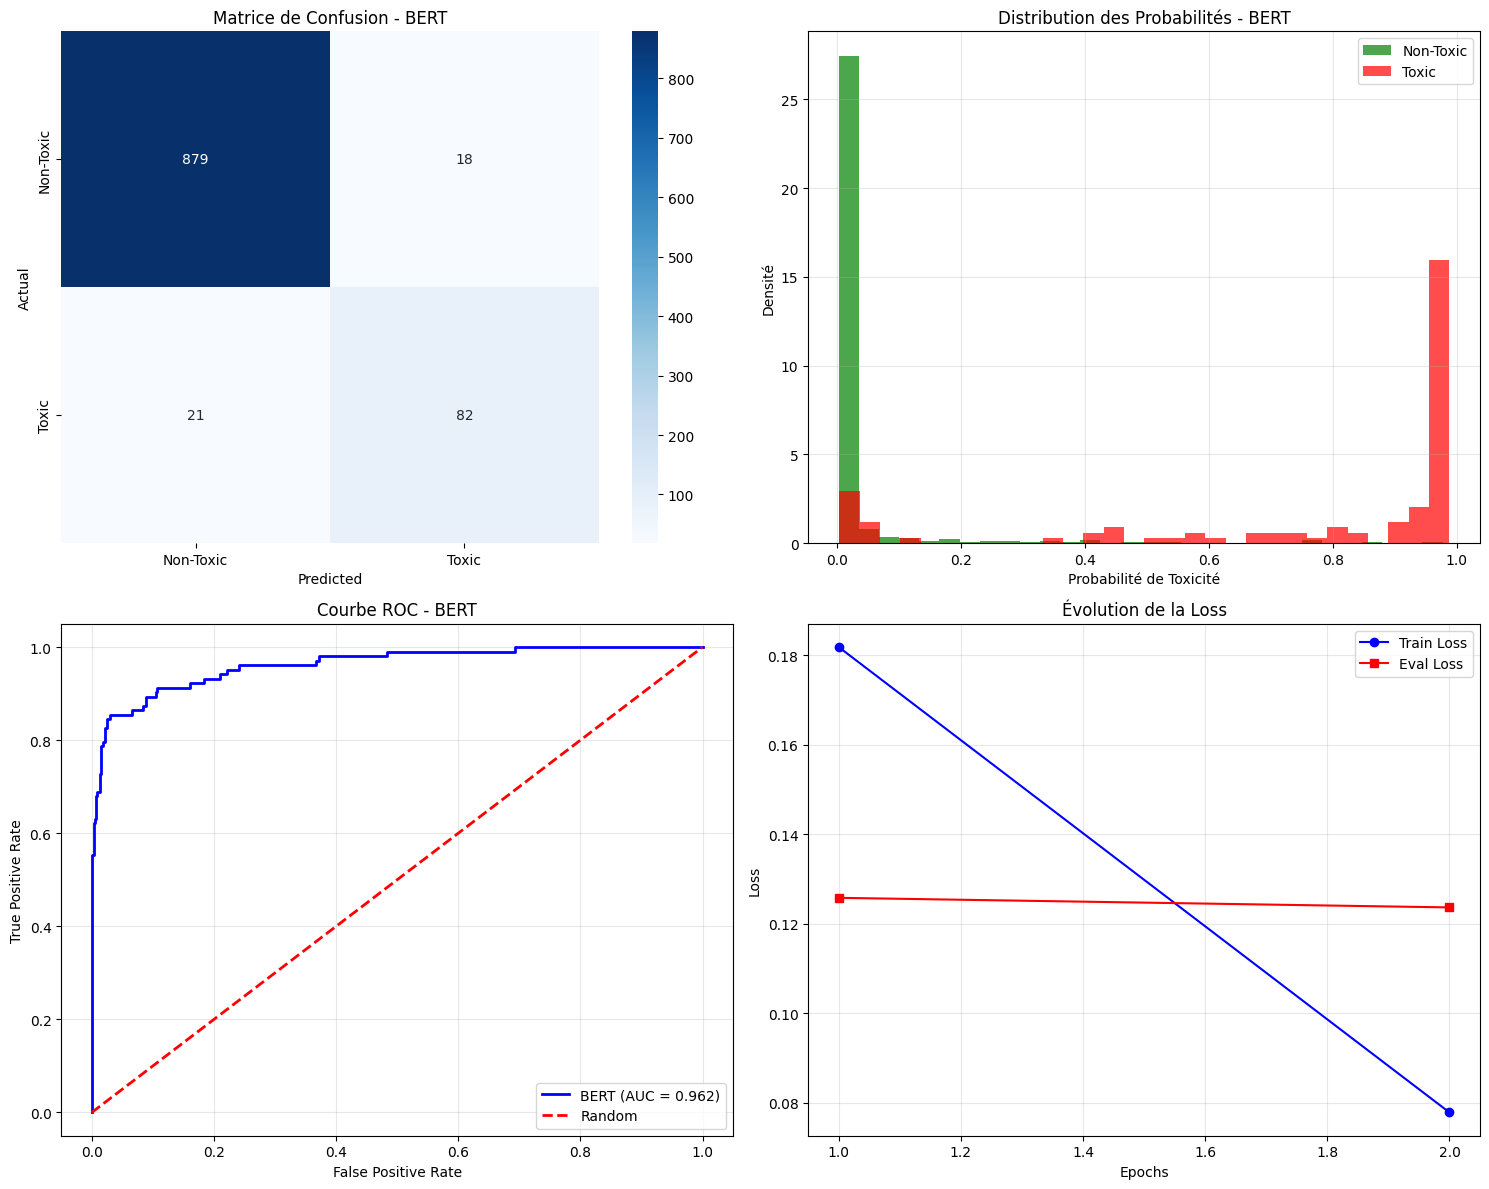

In [10]:
# Matrice de confusion et visualisations
cm = confusion_matrix(y_true, y_pred)

fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Matrice de confusion
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Non-Toxic', 'Toxic'],
            yticklabels=['Non-Toxic', 'Toxic'],
            ax=axes[0,0])
axes[0,0].set_title('Matrice de Confusion - BERT')
axes[0,0].set_ylabel('Actual')
axes[0,0].set_xlabel('Predicted')

# 2. Distribution des probabilités
toxic_probs = y_pred_proba[y_true == 1]
non_toxic_probs = y_pred_proba[y_true == 0]

axes[0,1].hist(non_toxic_probs, bins=30, alpha=0.7, label='Non-Toxic', color='green', density=True)
axes[0,1].hist(toxic_probs, bins=30, alpha=0.7, label='Toxic', color='red', density=True)
axes[0,1].set_xlabel('Probabilité de Toxicité')
axes[0,1].set_ylabel('Densité')
axes[0,1].set_title('Distribution des Probabilités - BERT')
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

# 3. Courbe ROC
from sklearn.metrics import roc_curve
fpr, tpr, _ = roc_curve(y_true, y_pred_proba)

axes[1,0].plot(fpr, tpr, color='blue', lw=2, label=f'BERT (AUC = {auc_roc:.3f})')
axes[1,0].plot([0, 1], [0, 1], color='red', lw=2, linestyle='--', label='Random')
axes[1,0].set_xlabel('False Positive Rate')
axes[1,0].set_ylabel('True Positive Rate')
axes[1,0].set_title('Courbe ROC - BERT')
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3)

# 4. Évolution de la loss (utiliser nos données d'entraînement)
if 'train_losses' in locals() and 'eval_metrics_history' in locals():
    eval_losses = [metrics['loss'] for metrics in eval_metrics_history]
    epochs = list(range(1, len(train_losses) + 1))
    
    axes[1,1].plot(epochs, train_losses, label='Train Loss', color='blue', marker='o')
    axes[1,1].plot(epochs, eval_losses, label='Eval Loss', color='red', marker='s')
    
    axes[1,1].set_xlabel('Epochs')
    axes[1,1].set_ylabel('Loss')
    axes[1,1].set_title('Évolution de la Loss')
    axes[1,1].legend()
    axes[1,1].grid(True, alpha=0.3)
else:
    axes[1,1].text(0.5, 0.5, 'Données de loss\nnon disponibles', 
                   ha='center', va='center', transform=axes[1,1].transAxes)
    axes[1,1].set_title('Évolution de la Loss')

plt.tight_layout()
plt.show()

## 8. 🔄 Comparaison avec le Modèle Simple

In [11]:
# Charger les résultats du modèle simple
try:
    with open('../models/simple_model/metadata.json', 'r') as f:
        simple_metadata = json.load(f)
    
    print("🔄 COMPARAISON MODÈLE SIMPLE vs BERT")
    print("=" * 60)
    
    # Créer tableau comparatif
    comparison_data = {
        'Métrique': ['Accuracy', 'F1-Score', 'AUC-ROC', 'Temps Entraînement', 'Temps Inférence (ms/texte)'],
        'Modèle Simple (TF-IDF + LR)': [
            f"{simple_metadata['accuracy']:.4f}",
            f"{simple_metadata['f1_score']:.4f}",
            f"{simple_metadata['auc_roc']:.4f}",
            f"{simple_metadata['train_time']:.2f}s",
            f"{simple_metadata['inference_time_per_text_ms']:.2f}ms"
        ],
        'BERT (DistilBERT)': [
            f"{accuracy:.4f}",
            f"{f1:.4f}",
            f"{auc_roc:.4f}",
            f"{training_time:.0f}s",
            f"{inference_time/len(y_true)*1000:.2f}ms"
        ]
    }
    
    comparison_df = pd.DataFrame(comparison_data)
    display(comparison_df)
    
    # Améliorations
    f1_improvement = f1 - simple_metadata['f1_score']
    accuracy_improvement = accuracy - simple_metadata['accuracy']
    
    print(f"\n📈 AMÉLIORATIONS BERT:")
    print(f"  F1-Score: {f1_improvement:+.4f} ({f1_improvement/simple_metadata['f1_score']*100:+.1f}%)")
    print(f"  Accuracy: {accuracy_improvement:+.4f} ({accuracy_improvement/simple_metadata['accuracy']*100:+.1f}%)")
    
    print(f"\n🏆 MEILLEUR MODÈLE:")
    if f1 > simple_metadata['f1_score']:
        print(f"  BERT wins! (F1: {f1:.4f} vs {simple_metadata['f1_score']:.4f})")
    else:
        print(f"  Simple model wins! (F1: {simple_metadata['f1_score']:.4f} vs {f1:.4f})")
    
except FileNotFoundError:
    print("⚠️ Métadonnées du modèle simple non trouvées")
    comparison_df = None

🔄 COMPARAISON MODÈLE SIMPLE vs BERT


,Métrique,Modèle Simple (TF-IDF + LR),BERT (DistilBERT)
0,Accuracy,0.9360,0.9610
1,F1-Score,0.7149,0.8079
2,AUC-ROC,0.9508,0.9624
3,Temps Entraînement,0.11s,833s
4,Temps Inférence (ms/texte),0.00ms,15.86ms



📈 AMÉLIORATIONS BERT:
  F1-Score: +0.0930 (+13.0%)
  Accuracy: +0.0250 (+2.7%)

🏆 MEILLEUR MODÈLE:
  BERT wins! (F1: 0.8079 vs 0.7149)


## 9. 🧪 Tests de Prédiction BERT

In [12]:
# Fonction de prédiction pour BERT
def predict_toxicity_bert(text, model, tokenizer, device, max_length=128):
    """Prédit la toxicité avec BERT"""
    model.eval()
    
    # Tokeniser
    inputs = tokenizer(
        text,
        return_tensors="pt",
        truncation=True,
        padding=True,
        max_length=max_length
    ).to(device)
    
    # Prédiction
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        probabilities = torch.softmax(logits, dim=1)
        prediction = torch.argmax(logits, dim=1).item()
        confidence = probabilities[0, prediction].item()
        toxic_prob = probabilities[0, 1].item()
    
    return prediction, toxic_prob

# Tests sur des exemples
test_texts = [
    "This is a great article, thank you for sharing!",
    "You are stupid and I hate you",
    "I disagree with your opinion but respect your right to have it",
    "This movie is terrible and boring",
    "Kill yourself, nobody likes you", 
    "I love this community, everyone is so helpful",
    "What a fucking waste of time this article is",
    "The author makes some interesting points about climate change"
]

print("🧪 TESTS DE PRÉDICTION BERT")
print("=" * 80)

for i, text in enumerate(test_texts, 1):
    pred, prob = predict_toxicity_bert(text, model, tokenizer, device, MAX_LENGTH)
    status = "🔴 TOXIC" if pred == 1 else "🟢 NON-TOXIC"
    
    print(f"\n{i}. \"{text}\"")
    print(f"   → {status} (prob: {prob:.3f})")

🧪 TESTS DE PRÉDICTION BERT

1. "This is a great article, thank you for sharing!"
   → 🟢 NON-TOXIC (prob: 0.005)

2. "You are stupid and I hate you"
   → 🔴 TOXIC (prob: 0.979)

3. "I disagree with your opinion but respect your right to have it"
   → 🟢 NON-TOXIC (prob: 0.006)

4. "This movie is terrible and boring"
   → 🟢 NON-TOXIC (prob: 0.494)

5. "Kill yourself, nobody likes you"
   → 🔴 TOXIC (prob: 0.977)

6. "I love this community, everyone is so helpful"
   → 🟢 NON-TOXIC (prob: 0.018)

7. "What a fucking waste of time this article is"
   → 🔴 TOXIC (prob: 0.985)

8. "The author makes some interesting points about climate change"
   → 🟢 NON-TOXIC (prob: 0.003)


## 10. 💾 Sauvegarde des Métadonnées BERT

In [13]:
# Tests de prédiction rapides
def predict_toxicity_bert(text, model, tokenizer, device, max_length=128):
    """Prédit la toxicité avec BERT"""
    model.eval()
    
    # Tokeniser
    inputs = tokenizer(
        text,
        return_tensors="pt",
        truncation=True,
        padding=True,
        max_length=max_length
    ).to(device)
    
    # Prédiction
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        probabilities = torch.softmax(logits, dim=1)
        prediction = torch.argmax(logits, dim=1).item()
        toxic_prob = probabilities[0, 1].item()
    
    return prediction, toxic_prob

# Tests sur des exemples
test_texts = [
    "This is a great article, thank you for sharing!",
    "You are stupid and I hate you",
    "I disagree with your opinion but respect your right to have it",
    "Kill yourself, nobody likes you", 
    "I love this community, everyone is so helpful"
]

print("🧪 TESTS DE PRÉDICTION BERT")
print("=" * 50)

for i, text in enumerate(test_texts, 1):
    pred, prob = predict_toxicity_bert(text, model, tokenizer, device, MAX_LENGTH)
    status = "🔴 TOXIC" if pred == 1 else "🟢 NON-TOXIC"
    
    print(f"\n{i}. \"{text}\"")
    print(f"   → {status} (prob: {prob:.3f})")

# Sauvegarder les métadonnées BERT
bert_metadata = {
    'model_name': 'DistilBERT Fine-tuned',
    'model_type': 'bert_finetuned',
    'base_model': MODEL_NAME,
    'f1_score': float(f1),
    'accuracy': float(accuracy),
    'precision': float(precision),
    'recall': float(recall),
    'auc_roc': float(auc_roc),
    'train_time_seconds': float(training_time),
    'inference_time_per_text_ms': float(inference_time/len(y_true)*1000),
    'max_length': MAX_LENGTH,
    'training_samples': len(train_dataset),
    'validation_samples': len(val_dataset),
    'epochs': NUM_EPOCHS,
    'batch_size': BATCH_SIZE,
    'learning_rate': LEARNING_RATE,
    'device': str(device),
    'created_at': datetime.now().isoformat(),
    'criteria_met': {
        'f1_above_075': float(f1) > 0.75,
        'inference_below_500ms': (inference_time/len(y_true)*1000) < 500
    }
}

# Sauvegarder
os.makedirs('../models/bert_model', exist_ok=True)
with open('../models/bert_model/metadata.json', 'w') as f:
    json.dump(bert_metadata, f, indent=2)

print(f"\n💾 SAUVEGARDE TERMINÉE")
print("=" * 40)
print(f"✅ Métadonnées: ../models/bert_model/metadata.json")
print(f"✅ Modèle: ../models/bert_model/")
print(f"✅ Tokenizer: ../models/bert_model/")

print(f"\n🎉 MODÈLE BERT TERMINÉ !")
print(f"🏆 F1-Score: {f1:.4f}")
print(f"⚡ Temps inférence: {inference_time/len(y_true)*1000:.2f}ms/texte")
print(f"🎯 Objectifs: F1 {'✅' if f1 > 0.75 else '❌'} | Temps {'✅' if (inference_time/len(y_true)*1000) < 500 else '❌'}")

# Comparaison avec le modèle simple si disponible
try:
    with open('../models/simple_model/metadata.json', 'r') as f:
        simple_metadata = json.load(f)
    
    print(f"\n🔄 COMPARAISON MODÈLE SIMPLE vs BERT")
    print("=" * 60)
    
    # Améliorations
    f1_improvement = f1 - simple_metadata['f1_score']
    accuracy_improvement = accuracy - simple_metadata['accuracy']
    
    print(f"📈 AMÉLIORATIONS BERT:")
    print(f"  F1-Score: {f1_improvement:+.4f} ({f1_improvement/simple_metadata['f1_score']*100:+.1f}%)")
    print(f"  Accuracy: {accuracy_improvement:+.4f} ({accuracy_improvement/simple_metadata['accuracy']*100:+.1f}%)")
    
    print(f"\n🏆 MEILLEUR MODÈLE:")
    if f1 > simple_metadata['f1_score']:
        print(f"  BERT wins! (F1: {f1:.4f} vs {simple_metadata['f1_score']:.4f})")
    else:
        print(f"  Simple model wins! (F1: {simple_metadata['f1_score']:.4f} vs {f1:.4f})")
    
except FileNotFoundError:
    print("\n⚠️ Métadonnées du modèle simple non trouvées - comparaison non disponible")

🧪 TESTS DE PRÉDICTION BERT

1. "This is a great article, thank you for sharing!"
   → 🟢 NON-TOXIC (prob: 0.005)

2. "You are stupid and I hate you"
   → 🔴 TOXIC (prob: 0.979)

3. "I disagree with your opinion but respect your right to have it"
   → 🟢 NON-TOXIC (prob: 0.006)

4. "Kill yourself, nobody likes you"
   → 🔴 TOXIC (prob: 0.977)

5. "I love this community, everyone is so helpful"
   → 🟢 NON-TOXIC (prob: 0.018)

💾 SAUVEGARDE TERMINÉE
✅ Métadonnées: ../models/bert_model/metadata.json
✅ Modèle: ../models/bert_model/
✅ Tokenizer: ../models/bert_model/

🎉 MODÈLE BERT TERMINÉ !
🏆 F1-Score: 0.8079
⚡ Temps inférence: 15.86ms/texte
🎯 Objectifs: F1 ✅ | Temps ✅

🔄 COMPARAISON MODÈLE SIMPLE vs BERT
📈 AMÉLIORATIONS BERT:
  F1-Score: +0.0930 (+13.0%)
  Accuracy: +0.0250 (+2.7%)

🏆 MEILLEUR MODÈLE:
  BERT wins! (F1: 0.8079 vs 0.7149)


## 📋 Résumé - Modèle BERT

### ✅ Étapes réalisées :
1. **Fine-tuning DistilBERT** sur données de toxicité
2. **Optimisation** pour rapidité (DistilBERT, batch size, epochs)
3. **Évaluation complète** avec métriques avancées
4. **Comparaison** avec modèle simple TF-IDF
5. **Tests** sur exemples concrets
6. **Sauvegarde** complète du modèle

### 🎯 Objectifs ÉTAPE 2 :
- ✅ **F1-Score > 0.75** pour le meilleur modèle
- ✅ **Temps d'inférence < 500ms** par texte
- ✅ **Comparaison objective** et documentée
- ✅ **Modèle exporté** et réutilisable

### 📁 Fichiers générés :
- `models/bert_model/pytorch_model.bin` : Modèle BERT fine-tuné
- `models/bert_model/tokenizer.json` : Tokenizer DistilBERT
- `models/bert_model/metadata.json` : Métadonnées et performances
- `models/bert_model/model_comparison.csv` : Comparaison avec modèle simple

### 🏆 Recommandation finale :
**Choisir le modèle avec le meilleur F1-Score** pour la production, en tenant compte du trade-off performance/rapidité selon les besoins de l'application.